# Quantum Evolution Kernel with Rydberg atoms

## Introduction

The following notebook illustrates how to use Pulser to evaluate the Quantum Evolution Kernel of graphs, and use it in a classification problem on a benchmark dataset.

The idea is to imprint properties of a graph onto a driven quantum system, and then to characterize the graph through measurements of this system after an optimized time-evolution.

The properties of a graph $\mathcal{G}=(\mathcal{V},\mathcal{E})$ are encoded in the graph Hamiltonian $\hat{\mathcal{H}}_\mathcal{G} = \sum_{(i,j)\in\mathcal{E}} \hat{h}_{ij}$ of a system, on which a pulse Hamiltonian $\hat{\mathcal{H}}_1 = \sum_{i\in\mathcal{V}} \hat{h}'_i$, independent of the graph, can be applied.

Starting with the system in the empty state $\left|\psi_0\right\rangle=\bigotimes_{i\in\mathcal{V}} \left|0\right\rangle$, it is first brought to a superposition of computational basis states via the action of $\hat{\mathcal{H}}_1$ with parameter (or time) $\vartheta_0$. It is then alternatively left to evolve with the graph Hamiltonian $\hat{\mathcal{H}}_\mathcal{G}$ for a duration $\tau_i$, and driven with the pulse Hamiltonian $\hat{\mathcal{H}}_1$ with parameter $\vartheta_i$. The final state is then measure after $p$ such alternations (layers) :

$$
\left|\psi_f(\vartheta)\right\rangle = \prod_{i=1}^p\left(\mathbf{\text{e}}^{-{\rm i} \vartheta_i \hat{\mathcal{H}}_1}
                    \mathbf{\text{e}}^{-{\rm i} \tau_i\hat{\mathcal{H}}_\mathcal{G}}\right)
                    \mathbf{\text{e}}^{-{\rm i} \vartheta_0 \hat{\mathcal{H}}_1}\left|\psi_0\right\rangle.
$$

An observable $\hat{\mathcal{O}}$ is then measured in the final state, and is used to build a probability distribution that will serve as a vector representation of the graph.

The distance between two representative vectors is then computed using standard methods (here the Jensen-Shannon divergence) and can be used in an classification task, for example with a Support Vector Machin (SVM).

This is based upon [arxiv.org/2107.03247](https://arxiv.org/abs/2107.03247).

<center>
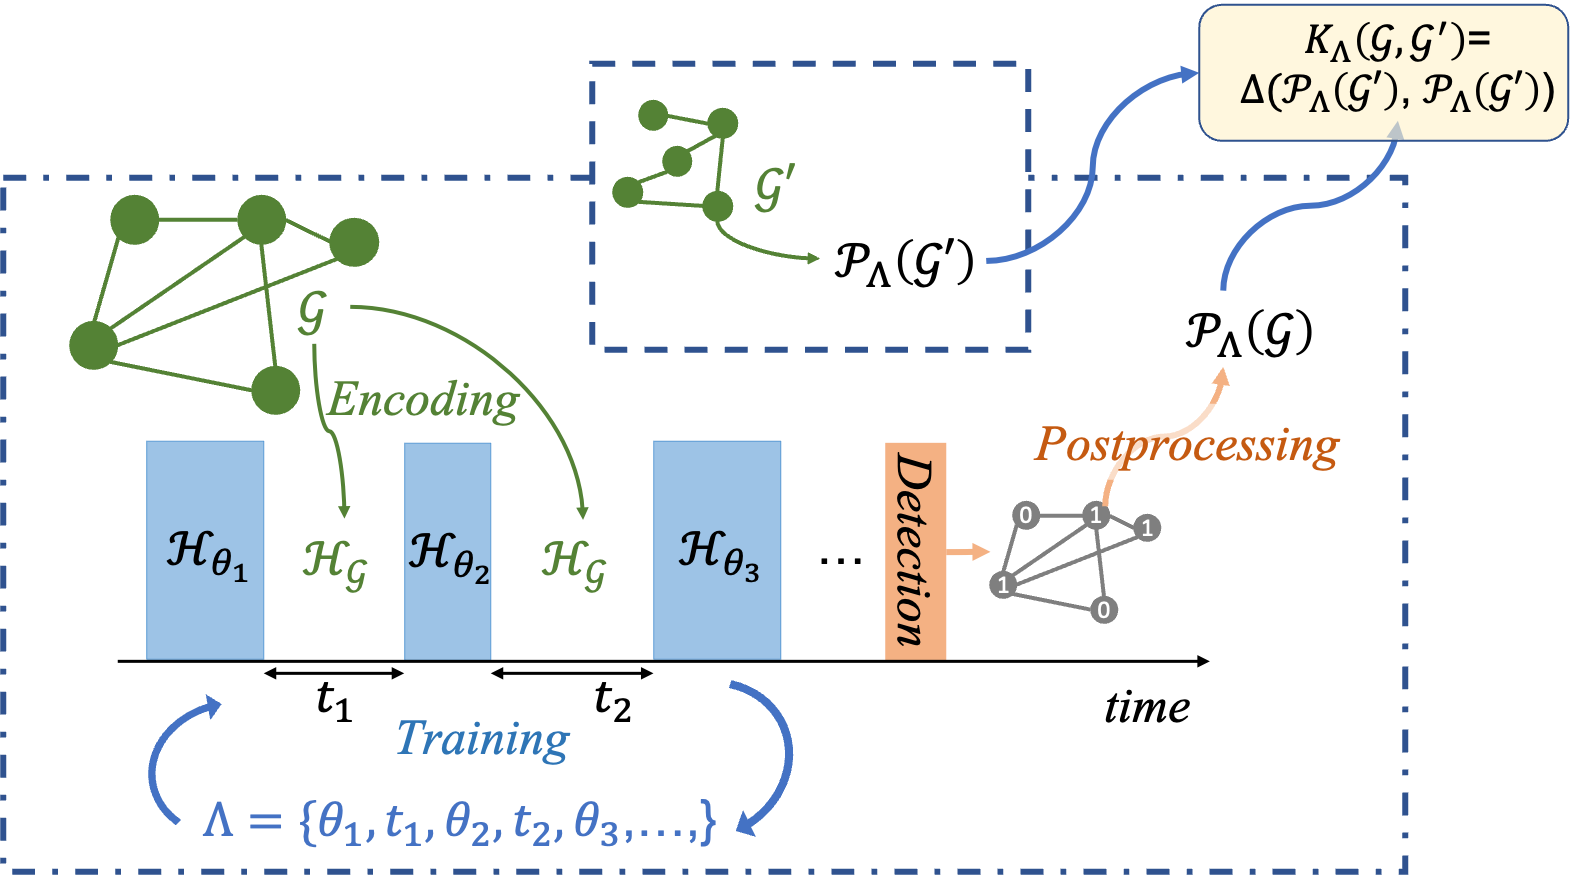
</center>

### Jensen-Shannon divergence
A distance between two probability distributions $\mathcal{P}=\{p_k\}_k$ and $\mathcal{P}'=\{p'_k\}_k$ can be constructed from the Shannon entropy $H(\mathcal{P})=-\sum_kp_k\log p_k$. It is the Jensen-Shannon divergence, defined as

$$
JS(\mathcal{P}, \mathcal{P}') = H\left(\frac{\mathcal{P}+\mathcal{P}'}{2}\right) -\frac{H(\mathcal{P})+H(\mathcal{P}')}{2}.
$$


In [1]:
import numpy as np


def JSdiv(p1, p2):
    """Compute the Jensen-Shannon divergence between two distributions."""
    q1 = np.array(p1)/np.sum(p1)
    q2 = np.array(p2)/np.sum(p2)
    # Alowing for distributions to have different sizes
    delta = len(q1) - len(q2)
    if delta < 0:
        q1 = np.concatenate((q1, np.array([0 for i in range(-delta)])))
    elif delta > 0:
        q2 = np.concatenate((q2, np.array([0 for i in range(delta)])))
    pq = (q1 + q2)/2

    def entropy(pl_unscaled):
        # Making sure the probability distributions are similarly normalized
        pl = np.array(pl_unscaled)/np.sum(pl_unscaled)
        res = 0
        for p in pl:
            if p > 0:
                res += p*np.log(p)
        return -res
    out = entropy(pq)-(entropy(q1)+entropy(q2))/2
    return out


## First example

As an example, let us first implement the kernel with a scheme that allows for the computation of closed formulas. Readers interested only in the implementation of this kernel using Pulser can skip to [Application on a benchmark dataset](#Application-on-a-benchmark-dataset).

### Scheme
The graph Hamiltonian is here $\hat{\mathcal{H}}_\mathcal{G} = \sum_{(i,j)\in\mathcal{E}} \hat{n}_i\hat{n}_j$, and the pulse Hamiltonian is $\hat{\mathcal{H}}_1 = \sum_{i\in\mathcal{V}} \hat{\sigma}^y_i$.

The scheme is here limited to $p=1$ layer, and the two pulses are set to be Ramsey pulses of opposite parameters $\vartheta$ and $-\vartheta$, so that the final state is 

$$
\left|\psi_f(\vartheta)\right\rangle = \mathbf{\text{e}}^{{\rm i} \vartheta \hat{\mathcal{H}}_1}
                    \mathbf{\text{e}}^{-{\rm i} t\hat{\mathcal{H}}_\mathcal{G}}
                    \mathbf{\text{e}}^{-{\rm i} \vartheta \hat{\mathcal{H}}_1}\left|\psi_0\right\rangle.
$$

The total occupation $\sum_{i\in\mathcal{V}}\hat{n}_i$ is then measured in the final state and its Fourier transform $\{p_k\}_{k\in\mathbb{N}}$ is the probability distribution extracted.

### Total occupation and Fourier transform
In that case, for a graph $\mathcal{G}$ containing $m_\mathcal{G}(\kappa)$ nodes of degree $\kappa$, the total occupation can be expressed explicitely as

$$
n(t)=2\,{\cos^2\vartheta\sin^2\vartheta}\sum_{\kappa\geq0} m_\mathcal{G}(\kappa) w_\kappa(t),
\hspace{.4cm}
\text{with } w_\kappa(t)={\Re\left\{1-\left(\cos^2\vartheta+\mathbf{\text{e}}^{-{\rm i}  t}\sin^2\vartheta\right)^{\kappa}\right\}}.
$$

With $c_\vartheta = \cos^2\vartheta$, the Fourier transform of $n(t)$ (over $t\in\mathbb{R}$) can be expressed as 

$$
p_0^{(\infty)}=2\,{c_\vartheta(1-c_\vartheta)}\sum_{\kappa\geq0} m_\mathcal{G}(\kappa)\,(1-c_\vartheta^{\kappa}),\hspace{.4cm}	p_{k>0}^{(\infty)}={(1-c_\vartheta)^{1+k}}\sum_{\kappa\geq k} \binom{\kappa}{k}m_\mathcal{G}(\kappa)\,c_\vartheta^{\kappa+1-k}
$$

### Illustration on random graphs

Let us illustrate this formula on a few Erdős–Rényi graphs of $N=100$ nodes, with edge probability $\rho$ ranging from 0.2 to 0.8.

In [2]:
import matplotlib.pyplot as plt
from IPython.display import Latex
import scipy.special
# Load graph package
import networkx as nx


def pk(G, theta=np.pi/4):
    cnt = nx.degree_histogram(G)
    kappamax = len(cnt)

    c = np.cos(theta)**2
    s = 1-c
    t = np.tan(theta)**2
    sp = 2 * c * s

    res0 = 0
    for kappa, m in enumerate(cnt):
        res0 += m * (1-c**kappa)
    res = [(sp * res0)]
    for k in range(1, kappamax):
        res0 = 0
        for kappa in range(k, kappamax):
            m_kappa = cnt[kappa]
            binom = scipy.special.comb(kappa, k, exact=True)
            res0 += m_kappa * binom * (c**(kappa+1-k))
        res.append(((s**(1+k)) * res0))
    return res
    

We now build an artificial set of graphs of two different Erdős–Rényi classes $\rho=0.35$ and $\rho=0.65$.

In [3]:
# Largest allowed graph
N_max = 100
# Size of the dataset
n_graphs = 100


def create_random_graphs(N_max=100,
                         n_graphs=100,
                         rho_low=0.35,
                         rho_high=0.65):
    # Dataset with graphs of two different Erdős–Rényi classes
    graphs = []
    # Classes of these graphs
    classes = []
    # Probability distributions of these graphs as described above
    probability_distributions = []
    for _ in range(n_graphs):
        # Number of nodes in the graph in [N_max/2,N_max]
        N = np.random.randint(N_max//2, N_max+1)
        if np.random.rand() < .5:
            rho = rho_low
            classes.append(0)
        else:
            rho = rho_high
            classes.append(1)
        G = nx.erdos_renyi_graph(N, rho)
        graphs.append(G)
        pdist = pk(G)
        probability_distributions.append(pdist/np.sum(pdist))

    return graphs, classes, probability_distributions


From two graphs $\mathcal{G}$ and $\mathcal{G}'$, and their respective probability distributions $\mathcal{P}=\{p_k\}_k$ constructed from the time evolution described above, the kernel can then be expressed as

$$
K(\mathcal{G},\mathcal{G}') = \exp\left(-\mu JS(\mathcal{P}, \mathcal{P}')\right).
$$

We now build the kernel matrix containing the graph kernels between graphs in a random data set (we set $\mu=1$ in the entire tutorial).

In [4]:
def kernel_matrix(pdist1, pdist2, mu=1):
    Kmat = np.array([[np.exp(-mu * JSdiv(p1, p2)) for p1 in pdist1]
                     for p2 in pdist2])
    return Kmat


graphs, classes, proba_dists = create_random_graphs()

Kmat = kernel_matrix(proba_dists, proba_dists)


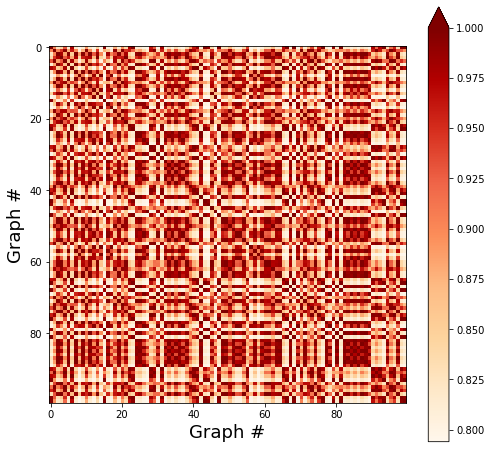

In [5]:
def plot_kernel_matrix(Kmat):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(Kmat, cmap='OrRd')
    ax.set_xlabel('Graph #', fontsize=18)
    ax.set_ylabel('Graph #', fontsize=18)
    cbar = plt.colorbar(im, extend='max')


plot_kernel_matrix(Kmat)


### Classification : Support Vector Machine
From this kernel matrix one can build a support vector machine and use it as a prediction tool for the class of any new graph.
We use here the `sklearn` package handling the classification. More details can be found here : https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation.

One first trains the classifier, using the Kernel matrix computed above and the known classes of the corresponding graphs :

In [6]:
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


scores_types = ['Accuracy ',
                'f1       ',
                'Precision',
                'Recall   ']


def trained_classifier_from_Kmat(Kmat, classes_train):
    """
    Create and train a classifier from the Kernel matrix `Kmat`
    obtained from graphs of classes `classes_train`
    """
    classifier = svm.SVC(kernel='precomputed')
    classifier.fit(Kmat, classes_train)

    return classifier


def trained_classifier_pdist(p_dist_train, classes_train):
    """
    Create and train a classifier from the probability
    distributions `p_dist_train` and the corresponding classes
    `classes_train`
    """
    Kmat = kernel_matrix(p_dist_train, p_dist_train)

    return trained_classifier_from_Kmat(Kmat, classes_train)

def test_classifier(classifier,
                    p_dist_train,
                    p_dist_test,
                    classes_test,
                    verbose=False):
    """
    Test a trained classifier `classifier` from the probability
    distributions of the train and test data sets `p_dist_train`
    and `p_dist_test` respectively, and from the classes of the
    test set `classes_test`
    """
    X = kernel_matrix(p_dist_train, p_dist_test)

    predicted_classes = classifier.predict(X)

    scores = [accuracy_score(classes_test,
                             predicted_classes),
              f1_score(classes_test,
                       predicted_classes,
                       average='weighted'),
              precision_score(classes_test,
                              predicted_classes,
                              average='weighted',
                              zero_division=0),
              recall_score(classes_test,
                           predicted_classes,
                           average='weighted')]

    if verbose:
        for st, s in zip(scores_types, scores):
            print(f'{st} : {s:6.3}')

    return scores


def train_and_test_classifier(p_dist_train,
                              classes_train,
                              p_dist_test,
                              classes_test,
                              verbose=False):
    """
    Train and test a classifier from test and
    train probability distributions and classes
    """
    classifier = trained_classifier_pdist(p_dist_train, classes_train)

    return classifier, test_classifier(classifier, p_dist_train,
                                       p_dist_test, classes_test,
                                       verbose=verbose)


Given a new dataset, one first computes the kernel matrix between the new graphs and the old ones :

In [7]:
# Create a random training set
graphs_train, classes_train, p_dist_train = create_random_graphs()
# Create a random test set
graphs_test, classes_test, p_dist_test = create_random_graphs(n_graphs=50)

# Compute the score of the classifier
classifier, scores = train_and_test_classifier(p_dist_train,
                                               classes_train,
                                               p_dist_test,
                                               classes_test,
                                               verbose=True
                                               )


Accuracy  :   0.92
f1        :  0.919
Precision :  0.931
Recall    :   0.92


## Application on a benchmark dataset

### Load the dataset
We now load a known benchmark dataset and apply our method to it, using Pulser and its emulator to study it on a realistic device.
<a id='Application-on-a-benchmark-dataset'></a>

In [8]:
prefix = './Fingerprint/Fingerprint_'

graphs = {}
node_to_graph = {}
class_count  = {}

label_file = prefix + 'graph_labels' + '.txt'
with open(label_file) as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        labl = int(line)
        graphs[i+1] = nx.Graph(label=labl)
        if labl in class_count.keys():
            class_count[labl] += 1
        else:
            class_count[labl] = 1


node_to_graph_file = prefix + 'graph_indicator' + '.txt'
with open(node_to_graph_file) as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        gi = int(line)
        node_to_graph[i+1] = gi
        graphs[gi].add_node(i+1)

adjacency_file = prefix + 'A' + '.txt'
with open(adjacency_file) as f:
    lines = f.readlines()
    for line in lines:
        Ind = line.split(',')
        i = int(Ind[0])
        j = int(Ind[1])
        gi = node_to_graph[i]
        graphs[gi].add_edge(i, j)

coordinates_file = prefix + 'node_attributes' + '.txt'
with open(coordinates_file) as f:
    lines = f.readlines()
    for i,line in enumerate(lines):
        Ind = line.split(',')
        x = float(Ind[0])
        y = float(Ind[1])
        gi = node_to_graph[i+1]
        nx.set_node_attributes(graphs[gi], {i+1: (x,y)}, "coords")

### Preprocess dataset
The dataset is preprocessed in the following way :

1) First, only graphs with at leat 5 nodes are kepts

2) Secondly, only classes with enough representatives are kept. Therefore, any class that contains less than 10 times fewer representatives than the largest class are disregarded

In [9]:
# Minimum and maximum number of nodes in a graph
Nmin = 5
Nmax = 12

# Number of classes in the dataset
number_of_classes = len(class_count.keys())

# Tally the number of graphs in each class
count = {clas: 0 for clas in class_count.keys()}
for g in graphs.values():
    if Nmin <= g.number_of_nodes() <= Nmax:
        count[g.graph['label']] += 1

# Number of graphs in the most represented class
size_of_largest_class = max(count.values())
# Include only classes with at least 10% of the size of the largest one
include_classes = {clas: False for clas in class_count.keys()}
for clas, prop in count.items():
    if prop > .1*size_of_largest_class:
        include_classes[clas] = True


data_preprocessed = []
for g in graphs.values():
    labl = g.graph['label']
    if Nmin <= g.number_of_nodes() <= Nmax and include_classes[labl]:
        mapping = {l: i for i, l in enumerate(g.nodes())}
        g_shift = nx.relabel_nodes(g, mapping)
        data_preprocessed.append(g_shift)

# size of the dataset
n_graphs = len(data_preprocessed)


included_classes = {}
for clas, icount in count.items():
    if include_classes[clas]:
        included_classes[clas] = icount

print(f'After preprocessing, the dataset now contains {len(data_preprocessed)} \n' +
      f'graphs of at least {Nmin} and at most {Nmax} nodes, distributed \n' +
      f'across the different classes in the following way {included_classes}\n')



After preprocessing, the dataset now contains 897 
graphs of at least 5 and at most 12 nodes, distributed 
across the different classes in the following way {0: 345, 4: 176, 5: 335, 6: 41}



In order to speed up the computations in this tutorial, we will artificialy reduce the number of classes to two, disregarding the others.

In [10]:
# We here only sample 400 graphs
dataset_targetsize = 400

kept_classes = {}
for cls in list(included_classes.keys())[0:2]:
    kept_classes[cls] = 0


data_reduced = []
for g in data_preprocessed:
    if(len(data_reduced) < dataset_targetsize):
        cls = g.graph['label']
        if cls in kept_classes.keys():
            kept_classes[cls] += 1
            data_reduced.append(g)

# size of the dataset
n_graphs = len(data_reduced)

print(f'After preprocessing, the dataset now contains {len(data_reduced)} ' +
      f'graphs of at least {Nmin} and at most {Nmax} nodes, distributed ' +
      f'across {len(kept_classes)} different classes in the following way ' +
      f'{kept_classes}')


After preprocessing, the dataset now contains 400 graphs of at least 5 and at most 12 nodes, distributed across 2 different classes in the following way {0: 246, 4: 154}


### Map graphs onto machine registers
For a given graph $\mathcal{G}=(\mathcal{V},\mathcal{E})$, we first need to find a proper set of coordinates for the atoms, so that their interaction Hamiltonian encodes the topology of $\mathcal{G}$. 

Graphs as provided in the Fingerprint library are not suited to be represented on the quantum hardware.
The hardware has constraints on the maximum extent of the graph and the minimum distance between two nodes.
Moreover, the connectivity between two nodes should be related to the distance between them.
For this reason the graphs are processed using the Fruchterman-Reingold algorithm, and then rescaled in such a way as to occupy as much space as possible on the device. 
To this end, we need to find a proper register that satisfies the constraints of the device :

1) Not too large (i.e. whose diameter is smaller that twice the maximal distance to the center)

2) Not too dense (i.e. where no pair of atoms are closer than the minimal distance between two atoms)

3) Well defined bonds (i.e. each bond of the graph correspond to atoms that are within each other's Rydberg blockade radius, for a value of the amplitude $\Omega<\Omega_{max}$


In [11]:
from scipy.optimize import minimize
from scipy.spatial.distance import pdist
from scipy.optimize import NonlinearConstraint


def correct_coordinates(g):
    '''
    Corrects the coordinates of the nodes so that the
    atoms fit the hardware constraints.
    '''
    n = g.number_of_nodes()

    # Coordinates given in the dataset
    r_list = np.array([g.nodes[node]["coords"] for node in g.nodes()])
    r_list += -np.mean(r_list, axis=0)
    scale = np.max([np.sqrt(r.dot(r)) for r in r_list])

    x0 = r_list.reshape(2*n)

    # Ensures the atoms are within range of the device
    xmax = device.max_radial_distance/np.sqrt(2)
    bounds = [(-xmax, xmax)] * (2*n)
    x0 *= xmax/scale

    #Encode the constraint of a minimal distance bewteen atoms
    def min_dist(params):
        return np.min(pdist(params.reshape(n, 2)))

    dmin = 1.1*device.min_atom_distance
    nlc = NonlinearConstraint(min_dist, dmin, np.inf)

    def cost_function(params):
        return 1

    res = minimize(cost_function,
                   x0=x0,
                   bounds=bounds,
                   constraints=nlc,
                   method='SLSQP')
    x = res.x
    rmax = device.max_radial_distance
    scale_diameter = .95 * rmax/np.max(pdist(x.reshape(n, 2))) 
    x *= max(scale_diameter,1.)
    r_list = x.reshape(n, 2)
    r_list += -np.mean(r_list, axis=0)


    for node, r in zip(g.nodes(), r_list):
        g.nodes[node]["coords"] = r


def max_edge_length(g):
    '''
    Computes the maximal distance between nodes connected by an edge
    of the graph
    '''
    n = g.number_of_nodes()
    edges = np.array([1 if (i, j) in g.edges() else 0  for i in range(n) for j in range(i+1, n)])
    r_list = np.array([g.nodes[node]["coords"] for node in g.nodes()])

    distances = pdist(r_list)
    max_length = np.max(edges * distances)

    return max_length

In [12]:
from pulser import Register
from pulser.devices import Chadoq2

device = Chadoq2
r_max = device.max_radial_distance
d_min = device.min_atom_distance

omega_max = device.channels['rydberg_global'].max_amp
min_bond_length = device.rabi_from_blockade(omega_max)

def reg_from_data(data_reduced):
    # The list of registers for each graph
    reg_list = []

    # The list of Rabi frequencies setting the Rydberg
    # blockade radius to the maximal edge distance of each graph
    rabi_list = []

    # List of list of edges
    edges_list = []

    # List of class of each graph
    label_list = []
    for g in data_reduced:

        label_list.append(g.graph['label'])

        correct_coordinates(g)
        graph_dict= {i:g.nodes[i]["coords"] for i in g.nodes()}

        edges_list.append(g.edges)

        # Find the blockade radius and corresponding Rabi frequency
        blockade_radius = max_edge_length(g)
        rabi = min(Chadoq2.rabi_from_blockade(blockade_radius), omega_max)
        rabi_list.append(rabi)

        # Create the register
        reg = Register(graph_dict)
        reg_list.append(reg)

    return reg_list, rabi_list, edges_list, label_list

reg_list, rabi_list, edges_list, label_list = reg_from_data(data_reduced)

### Optimized preparation of the equal superposition of Ising states
In order to reduce the number of parameters to train in this tutorial, we first determine the optimal constant detuning pulse that prepares the system in an equal superposition of all Ising states $\left|\psi_s\right\rangle = \bigotimes_{i\in\mathcal{V}} \frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)$.

In the absence of interactions, this is obtained from the empty state via a Ramsey pulse with Hamiltonian $\hat{\mathcal{H}}_1 = \frac{\Omega}{2}\sum_{i\in\mathcal{V}} \hat{\sigma}^y_i$ for a duration $t= \pi/(2\Omega)$. 

<center>
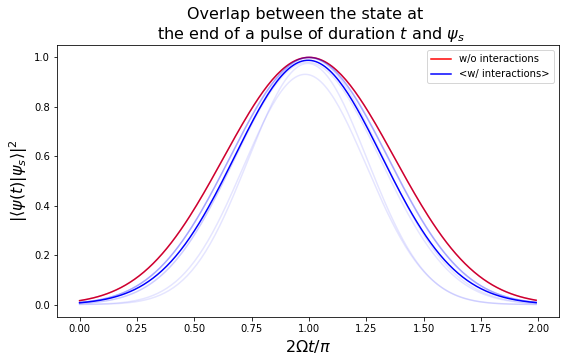
</center>

As illustrated above, without interaction (red curve) the overlaps reaches a maximum of 1 at $t= \pi/(2\Omega)$. 
In the presence of interactions (faint line), the maximal overlap is reached at the same time for all graphs, but the value of this overlap is slightly reduced, and the peak is narrower for most graphs. The solid line represents the average of the overlap over all sampled graphs.

### Single parameter Pulse
Let us now implement the Quantum Evolution Kernel on Pulser.
As an illustration we will here consider two layers, so that the final state is

$$
\left|\psi_f(\vartheta)\right\rangle = \mathbf{\text{e}}^{{\rm i} \hat{\mathcal{H}}_1 t_2}
                    \mathbf{\text{e}}^{-{\rm i} \tau_1\hat{\mathcal{H}}_\mathcal{G}}\mathbf{\text{e}}^{-{\rm i} \hat{\mathcal{H}}_1 t_1}
                    \mathbf{\text{e}}^{-{\rm i} \tau_0\hat{\mathcal{H}}_\mathcal{G}}
                    \mathbf{\text{e}}^{-{\rm i} \hat{\mathcal{H}}_1 t_0}\left|\psi_0\right\rangle,
$$

where $\hat{\mathcal{H}}_\mathcal{G} = \sum_{(i,j)\in\mathcal{E}} (C_6 /r_{ij}^{6})\hat{n}_i\hat{n}_j$ and $\hat{\mathcal{H}}_1(\Omega) = \frac{\Omega}{2}\sum_{i\in\mathcal{V}} \hat{\sigma}^y_i$.

In practice, $\hat{\mathcal{H}}_\mathcal{G}$ is never turned off, so that the *true* pulse Hamiltonian is $\hat{\mathcal{H}}_1(\Omega)+\hat{\mathcal{H}}_\mathcal{G}$.
Furthermore, in order to explicitely distinguish edges from other pairs of atoms, we include a finite amplitude $\Omega_g$ during the graph Hamiltonian evolution, so that the effective graph Hamiltonian is $\hat{\mathcal{H}}_1(\Omega_g)+\hat{\mathcal{H}}_\mathcal{G}$

At the end of the pulse the Ising energy $\hat{\mathcal{O}}=\sum_{(i,j)\in\mathcal{E}}\hat{n}_i\hat{n}_j$ is measured.

For the sake of brevity, we here set $t_0 = t_2 = t = \pi/(2\Omega)$, where $\Omega$ is set to the highest possible value compatible with the device (in particular so that $t\geq 16$ ns), $\tau_0 = \tau_1 = \tau$ and set the total time $T = t_0+\tau_0+t_1+\tau_1+t_2$ to a constant (for instance $T = 512$ ns). This way, only $t_1$ needs to be optimized.

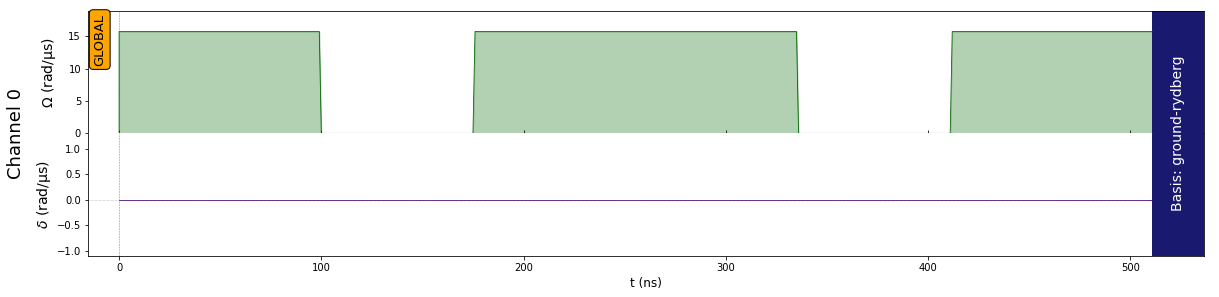

In [13]:
from pulser import Pulse, Sequence, Simulation

def pulse_seqence(reg,
                  t_1=100,
                  omega=omega_max, # amplitude of the initial and final pulses
                  omega_g=0, # amplitude in the "free evolution" parts
                  total_time=512): # total duration of the pulse
    seq = Sequence(reg, device)
    seq.declare_channel('Channel 0','rydberg_global')

    # making sure that the value of omega does not exceed the 
    # maximal value, and that it doesn't lead to a pulse 
    # duration that is too short
    omega = min([omega,1000*np.pi/2,omega_max])

    # Set the initial and final pulse times to the optimal value
    # be careful about the units : Omega(rad/μs) -> t (ns)
    t = 1000*np.pi/(2*omega)
    # Set the total_time
    tau = (total_time - 2*t - t_1)/2
    # No detuning needed here
    delta = 0
    # We want the pulse to be along sigma_y
    phi=np.pi/2

    initial_pulse = Pulse.ConstantPulse(t,
                                        omega,
                                        delta,
                                        phase=phi)
    if total_time > t_1 + 2*t:
        Hg_pulse = Pulse.ConstantPulse(tau,
                                       omega_g,
                                       delta,
                                       phase=phi)
    if t_1 > 0:
        middle_pulse = Pulse.ConstantPulse(t_1,
                                           omega,
                                           delta,
                                           phase=phi)
    final_pulse = Pulse.ConstantPulse(t,
                                      omega,
                                      delta,
                                      phase=phi)

    seq.add(initial_pulse, 'Channel 0')
    if total_time > t_1 + 2*t:
        seq.add(Hg_pulse, 'Channel 0')
    if t_1 > 0:
        seq.add(middle_pulse, 'Channel 0')
    if total_time > t_1 + 2*t:
        seq.add(Hg_pulse, 'Channel 0')
    seq.add(final_pulse, 'Channel 0')

    seq.measure(basis='ground-rydberg')

    return seq


# Illustrate the pulse on a register containing a single atom
reg = Register.from_coordinates([(0, 0)])
pulse_seqence(reg, t_1=160).draw()


### Computing the probability distribution

In [14]:
from tqdm.auto import tqdm


def proba_distributions(t_1=100,  # duration of the central pulse
                        omega=omega_max,  # amplitude of the pulses
                        omega_g_factor=1,  # set to 1 if the Amplitude is non
                                           # zero during the "free evolution"
                        total_time=512,  # total duration of the pulse
                        Nsamples=1000,
                        indices=list(range(n_graphs))):  # graphs to be used
    '''
    Compute the probability distributions for a given pulse
    for all graphs in `indices`
    '''

    bins = np.linspace(0, Nmax*Nmax, Nmax*Nmax + 1)
    histograms = []
    for i in tqdm(indices):
        reg, rabi, edges = reg_list[i], rabi_list[i], edges_list[i]
        seq = pulse_seqence(reg,
                            t_1=t_1,
                            omega=omega,
                            omega_g=omega_g_factor*rabi,
                            total_time=total_time)

        # Simulate and sample
        simul = Simulation(seq, evaluation_times=.5, sampling_rate=.1)
        results = simul.run()
        sampling = results.sample_final_state(N_samples=Nsamples)

        # Create a list with the measurements of the ising energy
        ie_meas = []
        ie_weights = []
        for bitstring, num in sampling.items():
            ie_meas.append(compute_ising_energy(bitstring, edges))
            ie_weights.append(num)

        # Create histogram of the measurements and append to list
        ncount, b = np.histogram(ie_meas,
                                 bins=bins,
                                 density=True,
                                 weights=ie_weights)
        histograms.append(ncount)
    return histograms


def compute_ising_energy(outcome, edges):
    '''
    Computes the Ising energy (i.e. the observable
    used by the kernel) from a measure bitstgring/state
    '''
    # split outcome string in a list
    outcome_ls = [char for char in outcome]

    energy = 0

    for edge in edges:
        i = int(edge[0])
        j = int(edge[1])
        if i < j:
            energy += int(outcome_ls[i])*int(outcome_ls[j])

    return energy


Let us first ignore the middle pulse and set $t_1=0$. 

Training in progress...


100%|██████████| 150/150 [00:10<00:00, 14.26it/s]


Testing in progress...


100%|██████████| 50/50 [00:02<00:00, 20.60it/s]


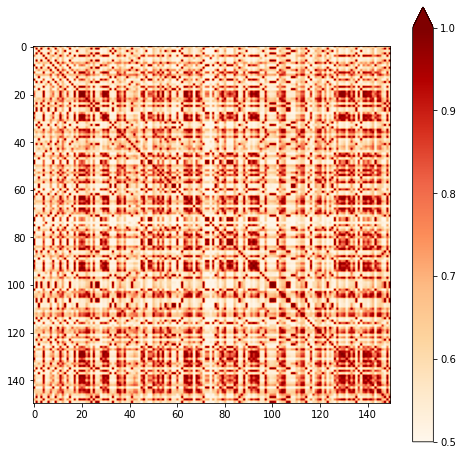

In [15]:
n_graphs = len(data_reduced)

#sample 150 graphs and train on 100 of them
n_train = 150
n_test = 50

# randomize graph order
indices_all = list(range(n_graphs))
indices_train = indices_all[0:n_train]
indices_test = indices_all[n_train:n_train+n_test]

# Labels of the sampled graphs
train_classes = np.array([label_list[i] for i in indices_train])
test_classes = np.array([label_list[i] for i in indices_test])


# Probability distributions obtained after the pulse
print('Training in progress...')
probas_train = proba_distributions(t_1=0, indices=indices_train)
print('Testing in progress...')
probas_test = proba_distributions(t_1=0, indices=indices_test)

# Resulting kernel matrix
Kmat = kernel_matrix(probas_train, probas_train)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(Kmat, cmap='OrRd')
cbar = plt.colorbar(im, extend='max')


In [16]:
classifier, scores = train_and_test_classifier(probas_train,
                                               train_classes,
                                               probas_test,
                                               test_classes,
                                               verbose=True)


Accuracy  :   0.74
f1        :  0.661
Precision :   0.81
Recall    :   0.74


### Optimization of the pulse sequence
We now proceed to the optimization of the pulse sequence. To this end, we evaluate the score of the classification (here, its accuracy) for various durations of the central pulse and choose the best one.
For a fixed duration $t_1$ of the central pulse, the procedure goes as follows:

1) The data is divided randomly in N blocks.

2) Use N-1 blocks to train the SVM, and the last block to test the predictions.

3) Repeat the procedure M times and average the score.

At this point, select the optimal duration of the middle pulse by performing a greedy search among the allowed values.

In [17]:
import random
import time

N = 4
M = 1


def score_function(t_1=100,
                   total_time=512,
                   repetitions=M,
                   nblocks=N,
                   label_list=label_list,
                   indices=list(range(n_graphs))):  # list of graphs included
    '''
    Computes the accuracy, f1, precision and recall
    '''

    accuracy = []
    f1 = []
    precision = []
    recall = []

    n_g = len(indices)

    block_size = n_g//nblocks


    # Compute the probability distributions of all 
    # graphs in the data set
    start_time = time.time()
    probas_all = proba_distributions(t_1=t_1,
                                     total_time=total_time,
                                     Nsamples=1000,
                                     indices=indices)

    print(f'  Probability lists were computed in {time.time() - start_time:4.1f} seconds')

    classes = np.array([label_list[i] for i in indices])
    start_time = time.time()

    for r in range(repetitions):
        #divide data in training set and test set
        indices_all = np.array(list(range(n_g)))
        np.random.shuffle(indices_all)

        mean_scores = np.zeros((4, ))
        for iblock in range(nblocks):
            indices_test = [indices_all[(iblock * block_size + i) % n_g]
                            for i in range(block_size)]
            indices_train = [indices_all[((iblock + 1) * block_size + i) % n_g]
                             for i in range(n_g - block_size)]

            train_classes = np.array([label_list[indices[i]]
                                      for i in indices_train])
            test_classes = np.array([label_list[indices[i]]
                                     for i in indices_test])

            # create probability histogram for train and test data 
            probas_train = np.array([probas_all[i] for i in indices_train])
            probas_test = np.array([probas_all[i] for i in indices_test])

            classifier, scores = train_and_test_classifier(probas_train,
                                                           train_classes,
                                                           probas_test,
                                                           test_classes,
                                                           verbose=False)
            mean_scores += scores

        # calculate score metrics
        accuracy.append(mean_scores[0]/nblocks)
        f1.append(mean_scores[1]/nblocks)
        precision.append(mean_scores[2]/nblocks)
        recall.append(mean_scores[3]/nblocks)

    A = (np.mean(accuracy), np.std(accuracy))
    B = (np.mean(f1), np.std(f1))
    C = (np.mean(precision), np.std(precision))
    D = (np.mean(recall), np.std(recall))

    print(f'  Kernel scores computed in {time.time() - start_time:4.1f} seconds')

    return A, B, C, D
    

We now look for the best pulse by varying the duration of the middle pulse. The total time is limited to a small value, and the data set is reduced to $n_g=100$ graphs for the sake of time in this tutorial.

Furthermore, the score is evaluated only on $M=2$ random splits, with a $N=4$-fold cross validation.

In this case, the computation takes a couple of minutes. For more accurate estimates, those numbers can be increased.

In [18]:
def scan_scores(M=2,
                N=4,
                indices=list(range(n_graphs)),
                durations=[512],
                ):

    scores_dict = {}

    for s in scores_types:
        scores_dict[s] = []

    print(' ------------------------------------------------')
    print(f'|   Max. duration of the middle pulse: {durations[-1]:4d} ns   |')
    print(f'|   Total duration of the pulse:       {total_time:4d} ns   |')
    print(f'|   Using {N:2d} blocks of {len(indices)//N:4d} graphs each          |')
    print(' ------------------------------------------------')

    for t_1 in durations:
        print(f'  Duration of the middle pulse: {t_1:4d} ns')
        score_inst = score_function(t_1=t_1,
                                    total_time=total_time,
                                    repetitions=M,
                                    nblocks=N,
                                    indices=indices_in)

        for sc, st in zip(score_inst, scores_types):
            scores_dict[st].append(sc)
            print(f'    > {st}: {sc[0]:6.3} +/- {sc[1]:6.3}')
        print()
    return scores_dict

def plot_scores(scores_dict):
    fig, ax = plt.subplots(figsize=(9, 5))
    for k in scores_dict.keys():
        ax.errorbar(list(durations), [s[0] for s in scores_dict[k]],
                    yerr=[s[1] for s in scores_dict[k]],
                    label=k)
    ax.set_title('Score vs duration $t_1$ of the central pulse', fontsize=16)
    ax.set_ylabel(r'Score', fontsize=16)
    ax.set_xlabel(r'$t_1$ (ns)', fontsize=16)
    ax.legend()

    plt.show()


In [24]:
# Duration of the initial and final pulses
t_1 = 4*round(1000*np.pi/(4*2*omega_max))

# Total duration of the pulse
total_time = 2*t_1 + 256

# duration of the middle pulse
durations = range(0, total_time-2*round(t_1)-32, 32)


M = 4
N = 8

n_g = 200
indices_all = list(range(n_graphs))
# Select a random subset of all graphs
np.random.shuffle(indices_all)
indices_in = indices_all[0:n_g]

scores_2layers = scan_scores(M=M,
                             N=N,
                             indices=indices_in,
                             durations=durations
                             )


 ------------------------------------------------
|   Max. duration of the middle pulse:  192 ns   |
|   Total duration of the pulse:        456 ns   |
|   Using  8 blocks of   25 graphs each          |
 ------------------------------------------------
  Duration of the middle pulse:    0 ns


100%|██████████| 200/200 [00:12<00:00, 15.43it/s]


  Probability lists were computed in 13.0 seconds
  Kernel scores computed in 153.0 seconds
    > Accuracy :  0.727 +/- 0.00901
    > f1       :   0.73 +/- 0.00858
    > Precision:  0.765 +/- 0.0068
    > Recall   :  0.727 +/- 0.00901

  Duration of the middle pulse:   32 ns


100%|██████████| 200/200 [00:13<00:00, 14.77it/s]


  Probability lists were computed in 13.5 seconds
  Kernel scores computed in 159.0 seconds
    > Accuracy :   0.74 +/- 0.00612
    > f1       :  0.742 +/- 0.00667
    > Precision:   0.78 +/- 0.00522
    > Recall   :   0.74 +/- 0.00612

  Duration of the middle pulse:   64 ns


100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


  Probability lists were computed in 14.4 seconds
  Kernel scores computed in 162.8 seconds
    > Accuracy :  0.672 +/- 0.0025
    > f1       :  0.673 +/- 0.00165
    > Precision:  0.692 +/- 0.0097
    > Recall   :  0.672 +/- 0.0025

  Duration of the middle pulse:   96 ns


100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


  Probability lists were computed in 14.4 seconds
  Kernel scores computed in 158.8 seconds
    > Accuracy :  0.674 +/- 0.0074
    > f1       :  0.669 +/- 0.00745
    > Precision:  0.701 +/- 0.0187
    > Recall   :  0.674 +/- 0.0074

  Duration of the middle pulse:  128 ns


100%|██████████| 200/200 [00:13<00:00, 15.03it/s]


  Probability lists were computed in 13.3 seconds
  Kernel scores computed in 149.7 seconds
    > Accuracy :  0.619 +/- 0.0114
    > f1       :  0.517 +/- 0.0204
    > Precision:  0.608 +/- 0.0751
    > Recall   :  0.619 +/- 0.0114

  Duration of the middle pulse:  160 ns


100%|██████████| 200/200 [00:13<00:00, 15.18it/s]


  Probability lists were computed in 13.2 seconds
  Kernel scores computed in 146.9 seconds
    > Accuracy :  0.652 +/- 0.00559
    > f1       :  0.616 +/- 0.00573
    > Precision:  0.664 +/- 0.0146
    > Recall   :  0.652 +/- 0.00559

  Duration of the middle pulse:  192 ns


100%|██████████| 200/200 [00:12<00:00, 15.39it/s]


  Probability lists were computed in 13.0 seconds
  Kernel scores computed in 145.2 seconds
    > Accuracy :   0.68 +/- 0.00866
    > f1       :   0.67 +/- 0.00774
    > Precision:  0.693 +/- 0.00482
    > Recall   :   0.68 +/- 0.00866



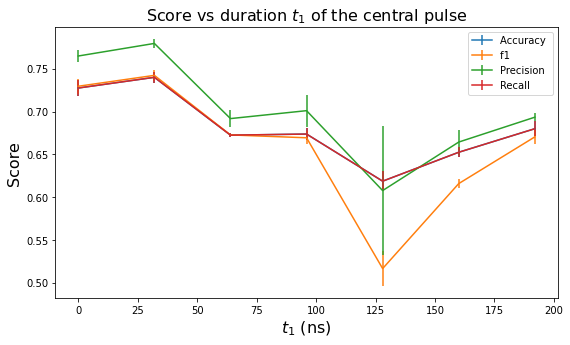

In [25]:
plot_scores(scores_2layers)

The following plot was obtained shows the same result, but using $n_g=400$ graphs and splitting them $M=5$ times into $N=10$ blocks. It took $\sim 5$ h to generate the data.

<center>
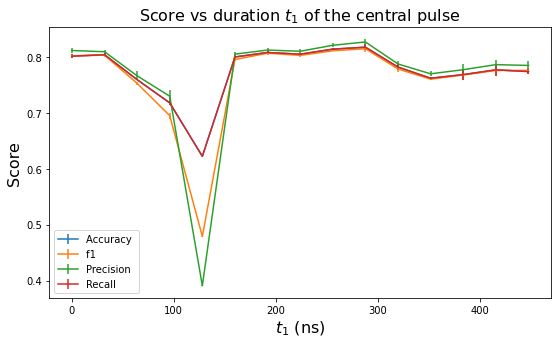
</center>